In [ ]:
from typing import TypedDict, List, Literal
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_community.utilities import SerpAPIWrapper
from IPython.display import Image, display
import os
from dotenv import load_dotenv
load_dotenv()

True

In [99]:
# ---------- state ----------
class State(TypedDict):
    messages: List[str]          # plain strings for readability

In [100]:
# ---------- LLM ----------
llm = ChatOllama(model="llama3.2", temperature=0)

In [101]:
# ---------- tools ----------
search = SerpAPIWrapper(
    serpapi_api_key=os.environ["SERPAPI_API_KEY"],
    params={'engine':'google_ai_mode'}
    )

In [102]:
def chat_node(state: State):
    # Call LLM and append its answer
    # build one prompt from history
    prompt = "\n".join(state["messages"]) + "\nAssistant:"
    ai_reply = llm.invoke(prompt).content
    return {"messages": state["messages"] + [ai_reply]}

In [103]:
keywords = [
    "don't have real-time information",
    "don't have real-time access",
    "don't have any information",
    "knowledge cutoff is december 2023",
    "my knowledge cutoff",
    "I do not have real-time"
    ]

In [104]:
def router(state: State) -> Literal["approve_search", "answer"]:
    # Look at the *AI reply* (last message) and decide.
    last = state["messages"][-1].lower()
    for i in keywords:
        if i.lower() in last:
            return "approve_search"
    return "answer"

In [105]:
def approve_search(state: State):
    # Ask user before burning API credits.
    cmd = input("The bot wants to call paid web search. Allow? (y/n)")
    if cmd.strip() != "y":
        return {"messages": state["messages"] + ["[User declined search]"]}
    # user said yes → run tool
    print("# ---------------- Giving response from API Calling ------------------- #")
    question = state["messages"][-2]   # user question is 2nd last
    output = search.results(question)

    # format the API Response 
    text_blocks = output["text_blocks"]
    good_responses = []
    for block in text_blocks:
        if(block['type'] == 'paragraph'):
            good_responses.append(block['snippet'])
        
    return {"messages": state["messages"] + [good_responses]}

In [106]:
def summarise(state: State):
    # Will give short answer to response generated from search API  
    API_response = state["messages"][-1][0]
    User_Question = state["messages"][-3].split('User:')[1]
    
    prompt = f"""
    Question: {User_Question}
    API Response: {API_response}
    
    Please provide a concise summary answer to the question based on the API response above.
    """
    summarised_output = llm.invoke(prompt).content
    return {"messages": state["messages"] + [summarised_output]}

In [107]:
def answer(state: State):
    """Normal reply path when no search is needed."""
    # already answered in chat_node, just END
    print("# ------------------ Just LLM Response ------------------- #")
    return {}

In [108]:
# ---------- graph ----------
builder = StateGraph(State)
builder.add_node("chat", chat_node)
builder.add_node("approve_search", approve_search)
builder.add_node("answer", answer)
builder.add_node("summarise",summarise)

builder.add_edge(START, "chat")
builder.add_conditional_edges("chat", router, {
    "approve_search": "approve_search",
    "answer": "answer"
})
builder.add_edge("approve_search", "summarise")
builder.add_edge("summarise",END)
builder.add_edge("answer", END)

In [109]:
graph = builder.compile()

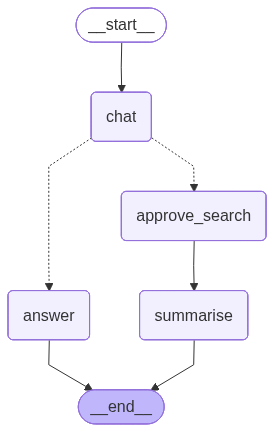

In [110]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [112]:
while True:
        q = input("\nYou: ")
        if q.lower() in {"exit", "quit","q"}:
            break
        # user question is appended *before* the graph runs
        state_in = {"messages": [f"User: {q}"]}
        final_state = graph.invoke(state_in)
        print(f'Question: {q}')
        print("Bot Answer:", final_state["messages"][-1])

# ---------------- Giving response from API Calling ------------------- #
Question: PM of india as of 2025?
Bot Answer: As of 2025, the Prime Minister of India is Narendra Modi.
# ---------------- Giving response from API Calling ------------------- #
Question: Who is 2025 women's odi world cup winning captian happend in India?
Bot Answer: The winning captain of the 2025 Women's ODI World Cup held in India was Harmanpreet Kaur.
# ------------------ Just LLM Response ------------------- #
Question: Authors of tranformers paper published in 2017 which is one of neural network architecture?
Bot Answer: The authors of the Transformer paper published in 2017 are:

1. Vaswani, Ashish
2. Shazeer, Noam
3. Parmar, Niki
4. Uszkoreit, Ilya
5. Jones, Aidan
6. Gomez, Łukasz
7. Polosukhin, Izabel

Their paper "Attention is All You Need" was published in the journal Nature in 2017 and introduced the Transformer architecture as a new type of neural network.
